# Supervised Machine Learning competition
## Multi-class classification

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from flaml import AutoML
from catboost import CatBoostClassifier, Pool

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Import data and store in DataFrames

In [2]:
df_feat_test = pd.read_csv('../data/raw/features_test.csv')
df_targ_train = pd.read_csv('../data/raw/target_train.csv')
df_feat_train = pd.read_csv('../data/raw/features_train.csv')

In [4]:
X_test_raw = df_feat_test
X_train_raw = df_feat_train
y_train = df_targ_train['Expected']

X_train = X_train_raw.drop(columns = ['Id'])
X_test = X_test_raw.drop(columns = ['Id'])

Data inspection

In [5]:
X_test.shape, X_train.shape, y_train.shape

((20000, 120), (10000, 120), (10000,))

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 120 entries, 0 to 119
dtypes: float64(120)
memory usage: 9.2 MB


In [6]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.000206e+00,1.653294,1.323895e+01,1.631063,1.004520e+00,1.011949e+00,0.520059,1.657632,-0.002513,1.671704,...,1.648705,0.497571,0.493227,1.635187,-0.000071,-0.026737,0.013010,1.620603,0.503886,1.667950
std,1.423822e+00,2.278088,1.870323e+01,2.040002,1.409997e+00,1.444751e+00,31.791384,2.116264,10.060025,2.251833,...,2.188790,0.285955,0.290153,1.975617,0.997596,10.082855,9.968787,2.117979,0.285662,2.203032
min,1.282517e-08,0.024358,7.274511e-07,0.020518,3.379589e-11,1.348884e-07,-129.141171,0.019514,-37.427526,0.028163,...,0.022037,0.000128,0.000217,0.016691,-3.885360,-34.580159,-40.925480,0.016396,0.000139,0.029379
25%,1.040056e-01,0.509503,1.318718e+00,0.512428,1.042731e-01,1.005381e-01,-21.037225,0.507242,-6.698098,0.512798,...,0.510389,0.252094,0.241741,0.511563,-0.677989,-6.804569,-6.904905,0.504073,0.260493,0.513686
50%,4.602140e-01,0.995946,6.109321e+00,0.994325,4.558152e-01,4.490724e-01,0.351341,0.998968,0.081728,0.996833,...,0.990977,0.496045,0.488491,0.999822,-0.006377,-0.109698,0.155250,1.002604,0.503294,1.003636
75%,1.295762e+00,1.943914,1.758705e+01,1.933788,1.339252e+00,1.336866e+00,21.714889,1.982386,6.818884,1.984666,...,1.944777,0.744041,0.747421,1.988738,0.669345,6.765366,6.820834,1.932612,0.748390,1.941041
max,1.601254e+01,72.033830,2.681004e+02,33.933547,1.684319e+01,1.812245e+01,118.399310,37.265489,38.392229,45.191073,...,36.698799,0.999973,0.999895,26.936000,3.737129,36.371289,34.679957,44.943499,0.999985,45.467996


In [8]:
X_train.isnull().sum().unique()

array([0], dtype=int64)

C:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\gammer\AppData\Local\anaconda3\envs\MLOps-dev\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


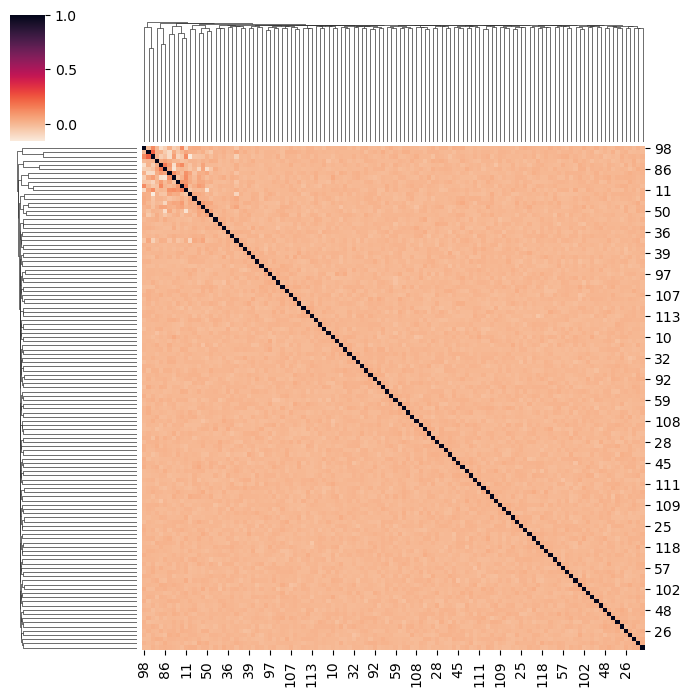

In [14]:
sns_plot = sns.clustermap(X_train.corr(), cmap="rocket_r", figsize=(7,7))

In [15]:
X_train.corr().unstack().sort_values(ascending=False).drop_duplicates()

0   0     1.000000
42  20    0.225950
37  86    0.173106
6   11    0.151067
42  98    0.127878
            ...   
74  37   -0.116483
37  98   -0.117223
50  11   -0.126067
86  74   -0.136069
60  42   -0.156317
Length: 7141, dtype: float64

In [ ]:
model_Cat = CatBoostClassifier(
         early_stopping_rounds = 10,
         learning_rate = 0.06692273485930686,
         n_estimators = 200,
         thread_count = -1,
         verbose = False,
         random_seed = 10242048,
         #od_type = "Iter",
         #od_wait = 10
)

In [ ]:
feats = model_Cat.select_features(X_train, y_train,
                         features_for_select=list(range(120)),
                         num_features_to_select=16)

In [ ]:
X_train_red = X_train.iloc[:,feats['selected_features']]
X_train_red.shape

In [ ]:
automl = AutoML()

In [ ]:
automl_settings = {
    "time_budget": 1200, # 20 mins to try and select best model
    "metric": 'macro_f1',
    "task": 'classification',
    "log_file_name": 'mylog.log',
    "eval_method": 'cv',
    "n_splits": 5
}

In [ ]:
automl.fit(X_train=X_train_red, y_train=y_train.values,
           **automl_settings)

In [ ]:
automl.best_estimator

In [ ]:
automl.best_config

In [ ]:
automl.model.get_params()

In [ ]:
predictions = automl.predict(X_train_red)
cf = confusion_matrix(y_train, predictions)
print(classification_report(y_train, predictions))
sns.heatmap(cf, annot=True);

# Use FLAML ensemble approach

In [ ]:
automl_ens = AutoML()

automl_ens.fit(X_train=X_train_red, y_train=y_train.values, ensemble=True,
           **automl_settings)

In [ ]:
automl_ens.best_estimator

In [ ]:
automl_ens.model

In [ ]:
predictions = automl_ens.model.predict(X_train_red)
cf = confusion_matrix(y_train, predictions)
print(classification_report(y_train, predictions))
sns.heatmap(cf, annot=True);

## Continue with CatBoost algorithm

In [99]:
model_Cat = CatBoostClassifier(
         early_stopping_rounds = 13,
         learning_rate = 0.04171721859304757,
         n_estimators = 2500,
         thread_count = -1,
         verbose = False,
         random_seed = 10242048,
         #od_type = "Iter",
         #od_wait = 10
)

In [100]:
model_Cat.fit(X_train_red, y_train)

In [101]:
cv_score = cross_val_score(model_Cat, X_train_red, y_train,
                           cv=5, scoring='f1_macro')
print(cv_score)
print(np.mean(cv_score))

[0.6900797  0.68053531 0.68903492 0.71367006 0.70220594]
0.6951051868677635


In [ ]:
list_feat_imp = model_Cat.get_feature_importance(data=Pool(X_train_red, label=y_train))

In [ ]:
plt.hist(list_feat_imp);

In [ ]:
list_feat_imp[list_feat_imp>1]

## Finetune CatBoost using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

catboost_tune = CatBoostClassifier(random_seed = 10242048,
                                   verbose = False,
                                   thread_count = -1)
                                  

grid_search = {
            'early_stopping_rounds': [10, 13],
            'min_data_in_leaf': [500],
            'learning_rate': [0.175],
            'n_estimators': [150],
            'l2_leaf_reg': [4]}


grid_search_obj = GridSearchCV(estimator=catboost_tune,
                               param_grid=grid_search,
                               scoring='f1_macro', cv=3, verbose=5, n_jobs=-1)

#grid_search_obj.fit(X_Train,Y_Train)



In [ ]:
grid_search_obj.fit(X_train_red,y_train)

In [ ]:
predictioncat = grid_search_obj.best_estimator_.predict(X_train_red)
print(confusion_matrix(y_train,predictioncat))
print(classification_report(y_train,predictioncat))

In [ ]:
pd.set_option('display.max_colwidth', None)

cv_result_df = pd.DataFrame({
    'Model Rank': grid_search_obj.cv_results_['rank_test_score'],
    'Model Hyperparams': grid_search_obj.cv_results_['params'],
    'Avg CV F1-macro': grid_search_obj.cv_results_['mean_test_score'],
    'Std Dev CV F1-macro': grid_search_obj.cv_results_['std_test_score'],
    'CV Fold 1 F1-macro': grid_search_obj.cv_results_['split0_test_score'],
    'CV Fold 2 F1-macro': grid_search_obj.cv_results_['split1_test_score'],
    'CV Fold 3 F1-macro': grid_search_obj.cv_results_['split2_test_score']
})


cv_result_df.sort_values(by=['Model Rank'], ascending=True)

## Use Hyperopt for Bayesian hyperparameter tuning

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [ ]:
space = {
    'learning_rate':  hp.choice('learning_rate', [0.04, 0.06]),
    'n_estimators': hp.choice('n_estimators', [600, 860, 1000]),
    'l2_leaf_reg' : hp.choice('l2_leaf_reg', [30, 100])
}

def objective(space):
    cat_model_opt = CatBoostClassifier(

                                        learning_rate = space['learning_rate'],
                                        n_estimators = space['n_estimators'],
                                        l2_leaf_reg = space['l2_leaf_reg'],
                                        min_data_in_leaf = 300,
                                        early_stopping_rounds = 13,
                                        random_seed = 10242048,
                                        verbose = False,
                                        thread_count = -1)
    
   
       
    f1 = cross_val_score(cat_model_opt, X_train_red, y_train, cv=5, scoring='f1_macro').mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest, # Tree parzen estimator
            max_evals=10,
            trials=trials)
best

In [ ]:
depth = {0: 6}
lrate = {0: 0.02, 1: 0.04, 2:0.06}
n_est = {0: 600, 1:860, 2:1000}
l2_reg = {0: 10, 1: 30, 2: 100}

optimal_cat = CatBoostClassifier(
                                       learning_rate = lrate[best['learning_rate']],
                                       l2_leaf_reg = l2_reg[best['l2_leaf_reg']],
                                       n_estimators = n_est[best['n_estimators']],
                                       min_data_in_leaf = 500,
                                        early_stopping_rounds = 5,
                                        random_seed = 10242048,
                                        verbose = False,
                                        thread_count = -1,
                                      ).fit(X_train_red,y_train)

In [ ]:
prediction_best_cat = optimal_cat.predict(X_train_red)
print(confusion_matrix(y_train,prediction_best_cat))
print(classification_report(y_train,prediction_best_cat))

In [ ]:
X_test_red = X_test.iloc[:,feats['selected_features']]
X_train_red.shape

In [ ]:
y_pred_automl = automl.predict(X_test_red)

In [ ]:
df_pred_automl = pd.DataFrame()
df_pred_automl['Id']=X_test_raw['Id']
df_pred_automl.set_index('Id', inplace=True)
df_pred_automl['Predicted'] = y_pred_automl.ravel()

In [ ]:
df_pred_automl.to_csv('df_pred_automl_2.csv')

In [102]:
y_pred_cat = model_Cat.predict(X_test_red)

In [103]:
df_pred_cat = pd.DataFrame()
df_pred_cat['Id']=X_test_raw['Id']
df_pred_cat.set_index('Id', inplace=True)
df_pred_cat['Predicted'] = y_pred_cat.ravel()

In [104]:
df_pred_cat.to_csv('df_pred_cat4.csv')

In [ ]:
y_pred_opt_cat = optimal_cat.predict(X_test_red)

In [ ]:
comp = pd.DataFrame(red_prediction == red_prediction_2)

In [ ]:
comp.sum()